In [ ]:
!pip install geopandas
!pip install folium
!pip install lightgbm
!pip install utm
!pip install geojson 
!pip install haversine

# folium 한글 설치
!pip install git+https://github.com/python-visualization/branca.git@master

# 시각화 도구 설치
!pip install plotnine #R 시각화 
!pip install folium #지도 시각화 

In [2]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [3]:
!pip install pickle5
import pickle5 as pickle

     |████████████████████████████████| 133kB 2.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218626 sha256=ac70533dcb6787c874d604dc16c69389c5aa1c0602805f3a97529187656f3cf9
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [4]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [5]:
import pandas as pd
import pickle5 as pickle
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
import folium 
import geopandas as gpd
import math
from tqdm.notebook import tqdm
import utm
from shapely.geometry import Point, Polygon
from haversine import haversine
from plotnine import *

## 1. 행정동 선형결합

In [6]:
df_demand =pd.read_pickle('/content/drive/My Drive/Project/Seoul/지수_결과/1014수정_인프라지수.pickle')[['행정동코드', '행정동', 'new수요지수','100분위']]
df_demand['100분위'] = df_demand['100분위'].astype(int)
df_demand['행정동코드'] = df_demand['행정동코드'].astype(int)
df_demand

,행정동코드,행정동,new수요지수,100분위
0,1165065100,양재1동,2.911910e-05,2
1,1153078000,오류제2동,7.399572e-05,6
2,1150063000,방화제1동,9.837376e-05,8
3,1138069000,진관동,5.887938e-05,5
4,1138062500,역촌동,1.043019e-04,8
...,...,...,...,...
419,1114057000,필동,5.739099e-07,1
420,1114059000,광희동,1.084052e-06,1
421,1111054000,삼청동,1.052168e-06,1
422,1114060500,을지로동,1.870521e-07,1


In [7]:
df_demand.sort_values(by = '100분위', ascending=False)

,행정동코드,행정동,new수요지수,100분위
316,1165066000,내곡동,2.459866e-04,10
290,1130560300,번2동,2.247890e-04,10
132,1121586000,구의제2동,1.355633e-04,10
28,1135070000,상계8동,1.697615e-04,10
281,1171067000,잠실2동,1.682111e-04,10
...,...,...,...,...
389,1141072000,북가좌제2동,4.375932e-07,1
390,1165058100,반포4동,2.956245e-07,1
394,1150060500,가양제3동,1.605111e-05,1
395,1150056000,화곡제3동,4.007872e-07,1


In [8]:
df_alone = pd.read_csv("/content/drive/My Drive/Project/Seoul/지수_결과/역수취한 최종 돌봄 틈새공백 인구.csv")
df_alone

,Unnamed: 0,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,0,1117051000,용산구,후암동,3.608846,0.003152,4
1,1,1117057000,용산구,원효로2동,3.445290,0.003107,4
2,2,1117064000,용산구,이촌2동,1.544051,0.003132,1
3,3,1117066000,용산구,이태원2동,1.508517,0.003337,1
4,4,1117069000,용산구,서빙고동,3.587631,0.003040,4
...,...,...,...,...,...,...,...
419,419,1120072000,성동구,송정동,1.773041,0.003189,2
420,420,1120067000,성동구,성수2가1동,2.749154,0.003167,3
421,421,1120053500,성동구,왕십리도선동,6.841889,0.003455,8
422,422,1120064500,성동구,옥수동,8.163456,0.003818,8


In [9]:
df_alone.sort_values(by = '돌봄틈새공백 분위', ascending=False)

,Unnamed: 0,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
92,92,1147051000,양천구,목1동,19.277092,0.003953,10
374,374,1135062100,노원구,중계1동,17.296338,0.003811,10
283,283,1171068000,송파구,잠실3동,14.454883,0.003526,10
98,98,1168072000,강남구,일원본동,11.540119,0.003435,10
310,310,1121581000,광진구,광장동,18.154043,0.003318,10
...,...,...,...,...,...,...,...
309,309,1121571000,광진구,화양동,1.415339,0.002912,1
50,50,1114052000,중구,소공동,0.691716,0.003953,1
213,213,1162069500,관악구,신림동,1.142016,0.003235,1
47,47,1111064000,종로구,이화동,1.050374,0.002959,1


In [10]:
# 소득 k=3
with open('/content/drive/My Drive/Project/Seoul/가공데이터/동3개/지수결과/행정동별_소득분위k=3_robustx.pkl', 'rb') as f:  
  df_income = pickle.load(f)
df_income

,행정동코드,읍면동명,시군구명,추정소득 k=3,소득분위
0,1171063100,가락1동,송파구,1075.939437,3
1,1171063200,가락2동,송파구,795.380296,5
2,1171062000,가락본동,송파구,883.647799,4
3,1153059500,가리봉동,구로구,286.246082,10
4,1154551000,가산동,금천구,415.400591,10
...,...,...,...,...,...
419,1117058000,효창동,용산구,679.568874,6
420,1117051000,후암동,용산구,531.189708,8
421,1123072000,휘경제1동,동대문구,623.533827,7
422,1123073000,휘경제2동,동대문구,686.604532,6


In [11]:
df_income.sort_values(by = '소득분위', ascending=False)

,행정동코드,읍면동명,시군구명,추정소득 k=3,소득분위
344,1114058000,장충동,중구,249.667757,10
79,1132052100,도봉제1동,도봉구,392.495243,10
254,1147061100,신월7동,양천구,285.492971,10
36,1138056000,구산동,은평구,389.533841,10
262,1132066000,쌍문제1동,도봉구,323.761117,10
...,...,...,...,...,...
271,1168054500,압구정동,강남구,2094.639886,1
59,1168053100,논현2동,강남구,1455.530854,1
266,1144055500,아현동,마포구,1521.597400,1
187,1144066000,서교동,마포구,1711.878350,1


#### merge

In [12]:
df_demand['행정동코드'] = df_demand['행정동코드'].astype(int)
df_alone['행정동코드'] = df_alone['행정동코드'].astype(int)
df_income['행정동코드'] = df_income['행정동코드'].astype(int)


df_1 = df_demand.merge(df_alone, on = '행정동코드')
df_final = df_1.merge(df_income, on='행정동코드')

df_final = df_final[['행정동코드', '시군구명_x', '행정동명', 'new수요지수','돌봄 틈새공백 인구','추정소득 k=3']]
df_final.columns = ['행정동코드', '시군구', '행정동명', '인프라지수','돌봄틈새공백인구','추정소득']
df_final

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득
0,1165065100,서초구,양재1동,2.911910e-05,20.058894,1145.104140
1,1153078000,구로구,오류2동,7.399572e-05,15.328145,900.900901
2,1150063000,강서구,방화1동,9.837376e-05,17.737957,793.541070
3,1138069000,은평구,진관동,5.887938e-05,24.789692,710.188053
4,1138062500,은평구,역촌동,1.043019e-04,11.221457,225.864927
...,...,...,...,...,...,...
419,1114057000,중구,필동,5.739099e-07,0.464104,561.980451
420,1114059000,중구,광희동,1.084052e-06,0.438543,959.067682
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,805.849309
422,1114060500,중구,을지로동,1.870521e-07,0.108253,470.294486


In [13]:
df_final['추정소득_inverse'] = df_final['추정소득'].max() - df_final['추정소득']
X = df_final[['인프라지수', '돌봄틈새공백인구', '추정소득_inverse']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

df_final['MinMax_수요지수'] =  pd.DataFrame(X_scale.sum(axis=1))
df_final

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,추정소득_inverse,MinMax_수요지수
0,1165065100,서초구,양재1동,2.911910e-05,20.058894,1145.104140,1555.467391,1.508789
1,1153078000,구로구,오류2동,7.399572e-05,15.328145,900.900901,1799.670630,1.598649
2,1150063000,강서구,방화1동,9.837376e-05,17.737957,793.541070,1907.030461,1.829233
3,1138069000,은평구,진관동,5.887938e-05,24.789692,710.188053,1990.383478,1.981171
4,1138062500,은평구,역촌동,1.043019e-04,11.221457,225.864927,2474.706604,1.828905
...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,5.739099e-07,0.464104,561.980451,2138.591079,0.876802
420,1114059000,중구,광희동,1.084052e-06,0.438543,959.067682,1741.503849,0.718440
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,805.849309,1894.722222,0.780216
422,1114060500,중구,을지로동,1.870521e-07,0.108253,470.294486,2230.277045,0.898380


In [17]:
df_final.corr()

,행정동코드,인프라지수,돌봄틈새공백인구,추정소득,추정소득_inverse,MinMax_수요지수
행정동코드,1.000000,0.002311,0.328812,0.233076,-0.233076,0.047883
인프라지수,0.002311,1.000000,0.298480,-0.062171,0.062171,0.786800
돌봄틈새공백인구,0.328812,0.298480,1.000000,0.193257,-0.193257,0.584946
추정소득,0.233076,-0.062171,0.193257,1.000000,-1.000000,-0.450518
추정소득_inverse,-0.233076,0.062171,-0.193257,-1.000000,1.000000,0.450518
MinMax_수요지수,0.047883,0.786800,0.584946,-0.450518,0.450518,1.000000


findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.


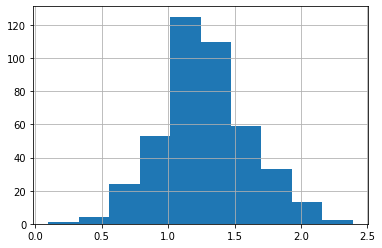

In [14]:
df_final['MinMax_수요지수'].hist()

In [15]:
df_X = pd.DataFrame(X_scale, columns = ['인프라', '돌봄공백', '소득'])
df_X

,인프라,돌봄공백,소득
0,0.112843,0.771715,0.624231
1,0.287029,0.589386,0.722234
2,0.381651,0.682263,0.765319
3,0.228355,0.954046,0.798769
4,0.404660,0.431110,0.993135
...,...,...,...
419,0.002046,0.016509,0.858247
420,0.004026,0.015524,0.698891
421,0.003902,0.015934,0.760379
422,0.000545,0.002794,0.895042


In [ ]:
df_final['인프라지수']  = df_X['인프라']
df_final['돌봄틈새공백인구']  = df_X['돌봄공백']
df_final['추정소득']  = df_X['소득']

In [ ]:
df_final = df_final.drop('추정소득_inverse', axis=1)
df_final

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수
0,1165065100,서초구,양재1동,0.112843,0.771715,0.624231,1.508789,1.119738
1,1153078000,구로구,오류2동,0.287029,0.589386,0.722234,1.598649,1.186426
2,1150063000,강서구,방화1동,0.381651,0.682263,0.765319,1.829233,1.357553
3,1138069000,은평구,진관동,0.228355,0.954046,0.798769,1.981171,1.470312
4,1138062500,은평구,역촌동,0.404660,0.431110,0.993135,1.828905,1.357310
...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,0.002046,0.016509,0.858247,0.876802,0.650713
420,1114059000,중구,광희동,0.004026,0.015524,0.698891,0.718440,0.533186
421,1111054000,종로구,삼청동,0.003902,0.015934,0.760379,0.780216,0.579032
422,1114060500,중구,을지로동,0.000545,0.002794,0.895042,0.898380,0.666727


## 현재 키움센터 개수와 비교

공식 = 동별 점수*91 / Sum(동별 점수의 합) - 현재 동별 센터의 개수

In [ ]:
df_supply = pd.read_pickle('/content/drive/My Drive/Project/Seoul/가공데이터/행정동별_주변공적돌봄시설.pickle')
df_supply

,행정동코드,시군구명,읍면동명,키움센터_상시돌봄정원,키움센터_일시돌봄정원,키움센터_개수,초등돌봄교실_이용인원,초등돌봄교실_교실개수,지역아동센터_정원,지역아동센터_개수,방과후아카데미_정원,방과후아카데미_개수
0,1111053000,종로구,사직동,0.0,0.0,0.0,65.0,3.0,0.0,0.0,0.0,0.0
1,1111054000,종로구,삼청동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1111055000,종로구,부암동,0.0,0.0,0.0,111.0,5.0,0.0,0.0,0.0,0.0
3,1111056000,종로구,평창동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1111057000,종로구,무악동,0.0,0.0,0.0,80.0,4.0,35.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
420,1174070000,강동구,둔촌제2동,0.0,0.0,0.0,153.0,7.0,50.0,1.0,0.0,0.0
421,1174057000,강동구,암사제1동,20.0,4.0,1.0,97.0,4.0,71.0,2.0,0.0,0.0
422,1174061000,강동구,천호제2동,0.0,0.0,0.0,100.0,4.0,59.0,2.0,0.0,0.0
423,1174068500,강동구,길동,0.0,0.0,0.0,255.0,13.0,129.0,5.0,0.0,0.0


In [ ]:
Sum = df_final['MinMax_수요지수'].sum()
print(Sum)

df_final['동별_필요센터수'] = df_final[['MinMax_수요지수']].apply(lambda x: x*400 / Sum)
df_final

538.9795025447067


,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수
0,1165065100,서초구,양재1동,0.112843,0.771715,0.624231,1.508789,1.119738
1,1153078000,구로구,오류2동,0.287029,0.589386,0.722234,1.598649,1.186426
2,1150063000,강서구,방화1동,0.381651,0.682263,0.765319,1.829233,1.357553
3,1138069000,은평구,진관동,0.228355,0.954046,0.798769,1.981171,1.470312
4,1138062500,은평구,역촌동,0.404660,0.431110,0.993135,1.828905,1.357310
...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,0.002046,0.016509,0.858247,0.876802,0.650713
420,1114059000,중구,광희동,0.004026,0.015524,0.698891,0.718440,0.533186
421,1111054000,종로구,삼청동,0.003902,0.015934,0.760379,0.780216,0.579032
422,1114060500,중구,을지로동,0.000545,0.002794,0.895042,0.898380,0.666727


In [ ]:
df_final.merge(df_supply[['행정동코드', '키움센터_개수']])

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수,키움센터_개수
0,1165065100,서초구,양재1동,0.112843,0.771715,0.624231,1.508789,1.119738,1.0
1,1153078000,구로구,오류2동,0.287029,0.589386,0.722234,1.598649,1.186426,1.0
2,1150063000,강서구,방화1동,0.381651,0.682263,0.765319,1.829233,1.357553,1.0
3,1138069000,은평구,진관동,0.228355,0.954046,0.798769,1.981171,1.470312,1.0
4,1138062500,은평구,역촌동,0.404660,0.431110,0.993135,1.828905,1.357310,1.0
...,...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,0.002046,0.016509,0.858247,0.876802,0.650713,0.0
420,1114059000,중구,광희동,0.004026,0.015524,0.698891,0.718440,0.533186,0.0
421,1111054000,종로구,삼청동,0.003902,0.015934,0.760379,0.780216,0.579032,0.0
422,1114060500,중구,을지로동,0.000545,0.002794,0.895042,0.898380,0.666727,0.0


In [ ]:
df_merge = df_final.merge(df_supply[['행정동코드', '키움센터_개수']])
df_merge['공급미달점수'] = df_merge[['동별_필요센터수', '키움센터_개수']].apply(lambda x: x['동별_필요센터수']-x['키움센터_개수'], axis=1)
df_merge

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수,키움센터_개수,공급미달점수
0,1165065100,서초구,양재1동,0.112843,0.771715,0.624231,1.508789,1.119738,1.0,0.119738
1,1153078000,구로구,오류2동,0.287029,0.589386,0.722234,1.598649,1.186426,1.0,0.186426
2,1150063000,강서구,방화1동,0.381651,0.682263,0.765319,1.829233,1.357553,1.0,0.357553
3,1138069000,은평구,진관동,0.228355,0.954046,0.798769,1.981171,1.470312,1.0,0.470312
4,1138062500,은평구,역촌동,0.404660,0.431110,0.993135,1.828905,1.357310,1.0,0.357310
...,...,...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,0.002046,0.016509,0.858247,0.876802,0.650713,0.0,0.650713
420,1114059000,중구,광희동,0.004026,0.015524,0.698891,0.718440,0.533186,0.0,0.533186
421,1111054000,종로구,삼청동,0.003902,0.015934,0.760379,0.780216,0.579032,0.0,0.579032
422,1114060500,중구,을지로동,0.000545,0.002794,0.895042,0.898380,0.666727,0.0,0.666727


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


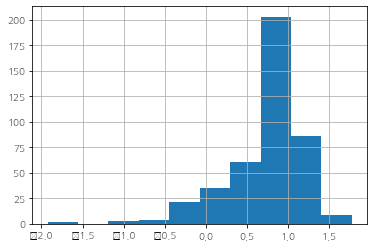

In [ ]:
df_merge['공급미달점수'].hist()

In [ ]:
df_merge.sort_values(by='공급미달점수', ascending = False).head(20)

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수,키움센터_개수,공급미달점수
15,1129066000,성북구,길음1동,0.801580,0.806575,0.781821,2.389976,1.773705,0.0,1.773705
265,1121581000,광진구,광장동,0.721764,0.698300,0.768797,2.188861,1.624449,0.0,1.624449
309,1171063100,송파구,가락1동,0.961767,0.440192,0.651988,2.053947,1.524323,0.0,1.524323
271,1147055000,양천구,목5동,0.300407,0.962913,0.764156,2.027476,1.504677,0.0,1.504677
41,1159068000,동작구,신대방2동,0.909984,0.223504,0.872536,2.006023,1.488757,0.0,1.488757
281,1171067000,송파구,잠실2동,0.652720,1.000000,0.331516,1.984236,1.472587,0.0,1.472587
63,1174055000,강동구,고덕1동,0.749728,0.608747,0.599296,1.957771,1.452946,0.0,1.452946
109,1165056000,서초구,반포1동,0.606225,0.685475,0.643774,1.935474,1.436399,0.0,1.436399
18,1147058000,양천구,신월3동,0.884472,0.130471,0.905836,1.920779,1.425493,0.0,1.425493
16,1174051500,강동구,강일동,0.661292,0.488894,0.731665,1.881851,1.396603,0.0,1.396603


In [ ]:
# 1순위 -> 먼저 설치해야 함
pt_list = np.percentile(df_merge[['공급미달점수']],[i*10 for i in range(2,10,2)]).tolist()

df_merge['공급미달점수_우선순위'] = 0
df_merge.loc[df_merge['공급미달점수'] <= pt_list[0], '공급미달점수_우선순위'] = 5
df_merge.loc[(df_merge['공급미달점수'] > pt_list[0]) & (df_merge['공급미달점수'] <= pt_list[1]),'공급미달점수_우선순위'] = 4
df_merge.loc[(df_merge['공급미달점수'] > pt_list[1]) & (df_merge['공급미달점수'] <= pt_list[2]),'공급미달점수_우선순위'] = 3
df_merge.loc[(df_merge['공급미달점수'] > pt_list[2]) & (df_merge['공급미달점수'] <= pt_list[3]),'공급미달점수_우선순위'] = 2
df_merge.loc[(df_merge['공급미달점수'] > pt_list[3]),'공급미달점수_우선순위'] = 1
df_merge

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수,키움센터_개수,공급미달점수,공급미달점수_우선순위
0,1165065100,서초구,양재1동,0.112843,0.771715,0.624231,1.508789,1.119738,1.0,0.119738,5
1,1153078000,구로구,오류2동,0.287029,0.589386,0.722234,1.598649,1.186426,1.0,0.186426,5
2,1150063000,강서구,방화1동,0.381651,0.682263,0.765319,1.829233,1.357553,1.0,0.357553,5
3,1138069000,은평구,진관동,0.228355,0.954046,0.798769,1.981171,1.470312,1.0,0.470312,4
4,1138062500,은평구,역촌동,0.404660,0.431110,0.993135,1.828905,1.357310,1.0,0.357310,5
...,...,...,...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,0.002046,0.016509,0.858247,0.876802,0.650713,0.0,0.650713,4
420,1114059000,중구,광희동,0.004026,0.015524,0.698891,0.718440,0.533186,0.0,0.533186,4
421,1111054000,종로구,삼청동,0.003902,0.015934,0.760379,0.780216,0.579032,0.0,0.579032,4
422,1114060500,중구,을지로동,0.000545,0.002794,0.895042,0.898380,0.666727,0.0,0.666727,4


In [ ]:
df_all = df_merge.merge(df_supply[['행정동코드','초등돌봄교실_교실개수','지역아동센터_개수','방과후아카데미_개수']]).sort_values(by='공급미달점수', ascending = False)
df_all.head(10)

,행정동코드,시군구,행정동명,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수,키움센터_개수,공급미달점수,공급미달점수_우선순위,초등돌봄교실_교실개수,지역아동센터_개수,방과후아카데미_개수
15,1129066000,성북구,길음1동,0.801580,0.806575,0.781821,2.389976,1.773705,0.0,1.773705,1,13.0,1.0,0.0
265,1121581000,광진구,광장동,0.721764,0.698300,0.768797,2.188861,1.624449,0.0,1.624449,1,13.0,0.0,0.0
309,1171063100,송파구,가락1동,0.961767,0.440192,0.651988,2.053947,1.524323,0.0,1.524323,1,6.0,0.0,0.0
271,1147055000,양천구,목5동,0.300407,0.962913,0.764156,2.027476,1.504677,0.0,1.504677,1,10.0,0.0,0.0
41,1159068000,동작구,신대방2동,0.909984,0.223504,0.872536,2.006023,1.488757,0.0,1.488757,1,9.0,2.0,1.0
281,1171067000,송파구,잠실2동,0.652720,1.000000,0.331516,1.984236,1.472587,0.0,1.472587,1,7.0,0.0,0.0
63,1174055000,강동구,고덕1동,0.749728,0.608747,0.599296,1.957771,1.452946,0.0,1.452946,1,10.0,1.0,0.0
109,1165056000,서초구,반포1동,0.606225,0.685475,0.643774,1.935474,1.436399,0.0,1.436399,1,8.0,1.0,0.0
18,1147058000,양천구,신월3동,0.884472,0.130471,0.905836,1.920779,1.425493,0.0,1.425493,1,4.0,6.0,1.0
16,1174051500,강동구,강일동,0.661292,0.488894,0.731665,1.881851,1.396603,0.0,1.396603,1,13.0,1.0,1.0


In [ ]:
df_all.groupby('공급미달점수_우선순위', as_index=False).agg('mean').drop('행정동코드', axis=1)

,공급미달점수_우선순위,인프라지수,돌봄틈새공백인구,추정소득,MinMax_수요지수,동별_필요센터수,키움센터_개수,공급미달점수,초등돌봄교실_교실개수,지역아동센터_개수,방과후아카데미_개수
0,1,0.496022,0.337259,0.813550,1.646831,1.222184,0.000000,1.222184,7.211765,1.623529,0.070588
1,2,0.280423,0.210632,0.822839,1.313895,0.975098,0.000000,0.975098,5.188235,1.388235,0.047059
2,3,0.200103,0.158896,0.771228,1.130226,0.838790,0.000000,0.838790,3.321429,0.964286,0.023810
3,4,0.143880,0.160320,0.652867,0.957068,0.710281,0.058824,0.651458,2.752941,0.482353,0.000000
4,5,0.352401,0.251991,0.701821,1.306213,0.969397,1.011765,-0.042368,5.717647,0.917647,0.070588


In [ ]:
df_all.to_excel('/content/drive/My Drive/Project/Seoul/1106_선형결합_행정동_오차계산.xlsx', index=False)

In [ ]:
len(df_all[df_all['공급미달점수_우선순위']==1]), len(df_all[df_all['공급미달점수_우선순위']==2]), len(df_all[df_all['공급미달점수_우선순위']==3]), len(df_all[df_all['공급미달점수_우선순위']==4]), len(df_all[df_all['공급미달점수_우선순위']==5])

(85, 85, 84, 85, 85)

## EDA

In [ ]:
# 각 돌봄기관 데이터 import
df_dolbom = gpd.read_file('/content/drive/My Drive/Project/Seoul/가공데이터/키움센터_위치_행정동.geojson')
df_local =  gpd.read_file('/content/drive/My Drive/Project/Seoul/가공데이터/지역아동센터_위치포함.geojson')
df_after =  gpd.read_file('/content/drive/My Drive/Project/Seoul/가공데이터/방과후아카데미_위치포함.geojson')

# 학교별 전체 데이터 import 
df_school = pd.read_pickle('/content/drive/My Drive/Project/Seoul/가공데이터/학교별_주변공적돌봄시설.pickle')

In [ ]:
dong_geo = gpd.read_file('/content/drive/My Drive/Project/Seoul/서울시_행정동경계/hangjeongdong_boundary.geojson')
dong_geo

In [ ]:
df_child_gu = pd.read_csv("/content/drive/My Drive/Project/Seoul/인구/초등학교별 전교생데이터.csv")
df_child_gu

In [ ]:
with open('/content/drive/My Drive/Project/Seoul/인구/행정동별_5-14세_거주인구.pkl', 'rb') as f:  
  df_child = pickle.load(f)

In [ ]:
df_child

In [ ]:
df_child_gu

In [ ]:
import folium 
from folium import plugins

center = (37.5642135, 127.0016985)
zoom = 13


m = folium.Map(location=center, zoom_start=zoom)
# m = folium.Map(location=center, zoom_start=zoom, tiles='cartodbpositron')
folium.Choropleth(
    geo_data = dong_geo,
    data = df_child_gu,
    columns = ('행정구역', '학생수'),
    key_on = 'feature.properties.시군구명',
    fill_color = 'Blues',
    legend_name = '초등학생_인구'
).add_to(m)

# 초등돌봄교실 
for index, row in df_school.iterrows():
  title = f"{row['학교명']} - 돌봄교실 인원: {row['초등돌봄교실_이용인원']}"
  # folium.Marker([row['초등학교_위도'], row['초등학교_경도']], popup=title, icon=folium.Icon(icon ='star', color = 'red')).add_to(m)
  folium.CircleMarker([row['초등학교_위도'], row['초등학교_경도']], popup=title, radius=1,color = 'red').add_to(m)
  # folium.Circle([row['초등학교_위도'], row['초등학교_경도']], radius =800, fill='#ececec', color = '#ececec').add_to(m)

# 우리동네키움센터 
for index, row in df_dolbom.iterrows():
  title = f"{row['시설ID']} - 상시: {row['상시돌봄']} - 일시: {row['일시돌봄']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='orange')).add_to(m)

# 지역아동센터
for index, row in df_local.iterrows():
  title = f"{row['시설명']} - 정원: {row['입소정원(명)']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='green')).add_to(m)

# 방과후아카데미
for index, row in df_after.iterrows():
  title = f"{row['시설명']} - 정원: {row['초등학생 수용인원(정원)']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='purple')).add_to(m)

m

In [ ]:
m.save('./공적돌봄시설_초등학생인구구별.html')

In [ ]:
import folium 
from folium import plugins

center = (37.5642135, 127.0016985)
zoom = 13


m = folium.Map(location=center, zoom_start=zoom)
# m = folium.Map(location=center, zoom_start=zoom, tiles='cartodbpositron')
folium.Choropleth(
    geo_data = dong_geo,
    data = df_child,
    columns = ('동', '5~14세'),
    key_on = 'feature.properties.읍면동명',
    fill_color = 'Blues',
    legend_name = '초등학생_인구'
).add_to(m)

# 초등돌봄교실 
for index, row in df_school.iterrows():
  title = f"{row['학교명']} - 돌봄교실 인원: {row['초등돌봄교실_이용인원']}"
  # folium.Marker([row['초등학교_위도'], row['초등학교_경도']], popup=title, icon=folium.Icon(icon ='star', color = 'red')).add_to(m)
  folium.CircleMarker([row['초등학교_위도'], row['초등학교_경도']], popup=title, radius=1,color = 'red').add_to(m)
  # folium.Circle([row['초등학교_위도'], row['초등학교_경도']], radius =800, fill='#ececec', color = '#ececec').add_to(m)

# 우리동네키움센터 
for index, row in df_dolbom.iterrows():
  title = f"{row['시설ID']} - 상시: {row['상시돌봄']} - 일시: {row['일시돌봄']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='orange')).add_to(m)

# 지역아동센터
for index, row in df_local.iterrows():
  title = f"{row['시설명']} - 정원: {row['입소정원(명)']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='green')).add_to(m)

# 방과후아카데미
for index, row in df_after.iterrows():
  title = f"{row['시설명']} - 정원: {row['초등학생 수용인원(정원)']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='purple')).add_to(m)

m

In [ ]:
import folium 
from folium import plugins

center = (37.5642135, 127.0016985)
zoom = 13


m = folium.Map(location=center, zoom_start=zoom)
# m = folium.Map(location=center, zoom_start=zoom, tiles='cartodbpositron')
folium.Choropleth(
    geo_data = dong_geo,
    data = df_child,
    columns = ('동', '5~14세'),
    key_on = 'feature.properties.읍면동명',
    fill_color = 'Blues',
    legend_name = '초등학생_인구'
).add_to(m)

# 초등돌봄교실 
for index, row in df_school.iterrows():
  title = f"{row['학교명']} - 돌봄교실 인원: {row['초등돌봄교실_이용인원']}"
  # folium.Marker([row['초등학교_위도'], row['초등학교_경도']], popup=title, icon=folium.Icon(icon ='star', color = 'red')).add_to(m)
  folium.CircleMarker([row['초등학교_위도'], row['초등학교_경도']], popup=title, radius=1,color = 'red').add_to(m)
  # folium.Circle([row['초등학교_위도'], row['초등학교_경도']], radius =800, fill='#ececec', color = '#ececec').add_to(m)

# 우리동네키움센터 
for index, row in df_dolbom.iterrows():
  title = f"{row['시설ID']} - 상시: {row['상시돌봄']} - 일시: {row['일시돌봄']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='orange')).add_to(m)

# 지역아동센터
for index, row in df_local.iterrows():
  title = f"{row['시설명']} - 정원: {row['입소정원(명)']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='green')).add_to(m)

# 방과후아카데미
for index, row in df_after.iterrows():
  title = f"{row['시설명']} - 정원: {row['초등학생 수용인원(정원)']}"
  folium.Marker([row['Latitude'], row['Longitude']], popup=title,icon=folium.Icon(icon = 'dumbell', color='purple')).add_to(m)

m

In [ ]:
m.save('/content/공적돌봄시설_초등학생인구_동별.html')